# Popular Data Science Questions
by Nicholas Archambault

The goal of this project is to use Data Science Stack Exchange -- a question and answer site for data scientists, machine learning professionals, and others interested in the field -- to determine which content a data science company should create based on the site's most popular subjects.

Most questions on the site are practical, specific to data science, and relevant to other posts. The DSSE homepage divides into four main sections:
   * Questions - a list of all questions asked
   * Tags - a list of labels and keywords that classify questions
   * Users - a list of users
   * Unanswered - a list of unanswered questions
   
The tagging system utilized by the site seems like a good way to quantify interest in particular subjects and proceed toward our goal of recommending content creation based on topics' popularity.

Upon further examination, we find that exploring tags from the 'Posts' data table, a collection of all posts, will give us an idea of the most popular topics on the site. This information can be used to understand which content should be created in order to most directly appeal to the site's audience.

We can query the posted question data we want from using the site's SQL interface:

`SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;`

## Exploring the Data

Read in the data, immediately ensuring that `Creation Date` is read as a datetime object. We'll limit our analysis to posts from 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("2019_questions.csv", parse_dates = ["CreationDate"])

In [3]:
data.head(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
data.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

In [5]:
data.shape

(8839, 7)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


The only column with missing values is 'FavouriteCount'.  Of 8,839 values, 7,432 in that column are missing. Missing values likely mean the given question was not present in any user's favorite list.  We can probably replace missing values with 0.

## Cleaning the Data

Each listing in the "Tags" column is a string.  We can clean these entries and keep them as lists of all the tags that apply to each post.

In [7]:
# Start with 'FavoriteCount' column
data["FavoriteCount"] = data["FavoriteCount"].fillna(0).astype(int)

In [8]:
# Continue with 'Tags'
data["Tags"] = data["Tags"].str.replace("><", ",").str.replace("<|>", "").str.split(",")

## Tags and Views

To measure tag popularity, count how many times each tag was used and how many times a question with that tag was viewed.

### Tags

In [9]:
# Create dictionary; increment value each time a tag is used
total_tags = {}
for row in data["Tags"]:
    for i in row:
        if i in total_tags:
            total_tags[i] += 1
        else:
            total_tags[i] = 1

In [10]:
# Transform into a dataframe for order
tag_count = pd.DataFrame.from_dict(data = total_tags, orient = "index")

In [11]:
tag_count.rename(columns = {0:"Count"}, inplace = True)
tag_count = tag_count.sort_values(by = "Count")
most_used = tag_count.tail(20)

The choice to view the 20 most popular tags is arbitrary, but we see that popularity declines rapidly and suspect that we are not neglecting any tags too important to the conclusions we'll draw.

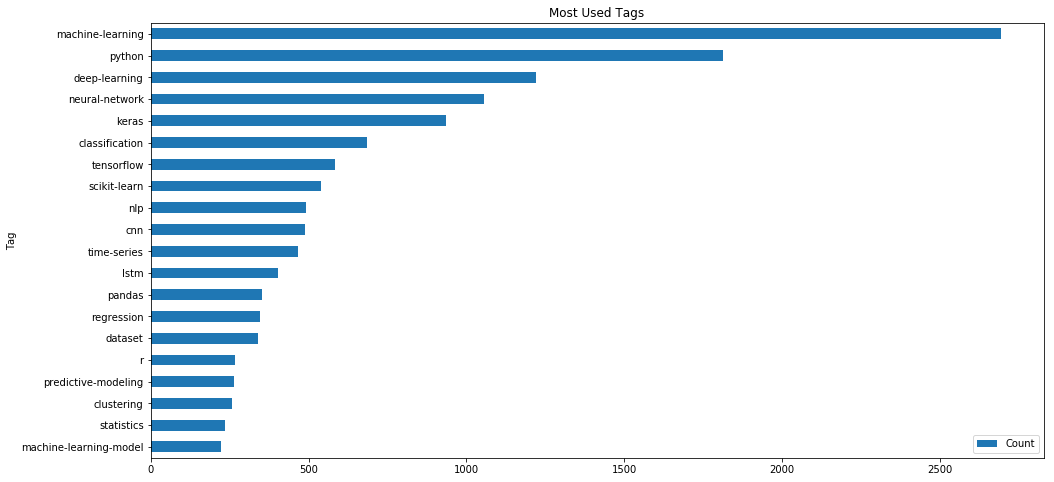

In [12]:
# Plot popular tags
most_used.plot(kind = "barh", figsize = (16,8))
plt.title("Most Used Tags")
plt.ylabel("Tag")
plt.show()

Visualizing the data reveals that some tags -- including 'machine-learning' and 'dataset' -- are a bit too broad to be useful for suggesting new, specific content to be created. 

Let's see how the trends of overall views compare to the trends observed in tag popularity. We can repeat the same process of accumulating counts, converting to a dataframe, sorting the values, and plotting the results.

### Views
Repeat previous steps.

In [13]:
tag_views = dict()
for index, row in data.iterrows():
    for i in row["Tags"]:
        if i in tag_views:
            tag_views[i] += row["ViewCount"]
        else:
            tag_views[i] = row["ViewCount"]

In [14]:
total_views = pd.DataFrame.from_dict(tag_views, orient = "Index")

In [15]:
total_views.rename(columns={0:"Views"}, inplace = True)
total_views = total_views.sort_values(by = "Views")
most_viewed = total_views.tail(20)

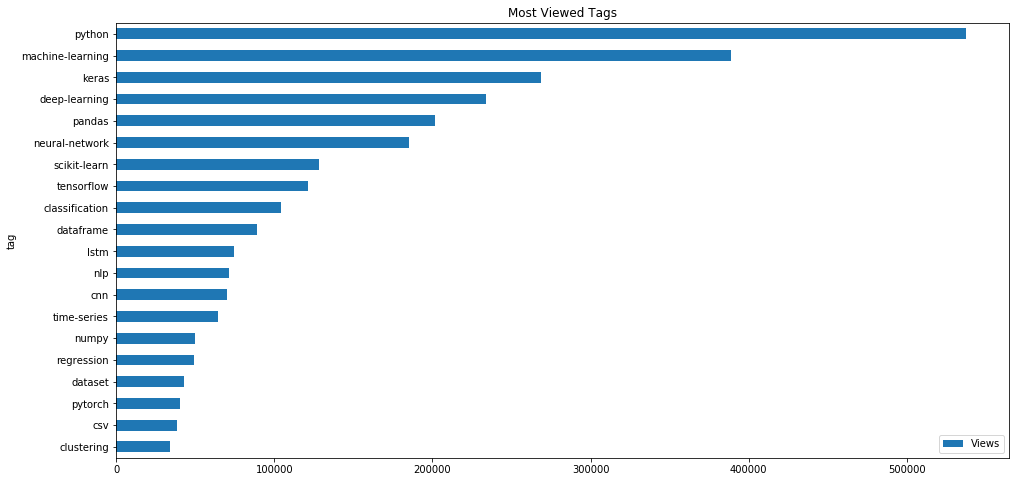

In [16]:
most_viewed.plot(kind = "barh", figsize = (16,8))
plt.title("Most Viewed Tags")
plt.ylabel("tag")
plt.show()

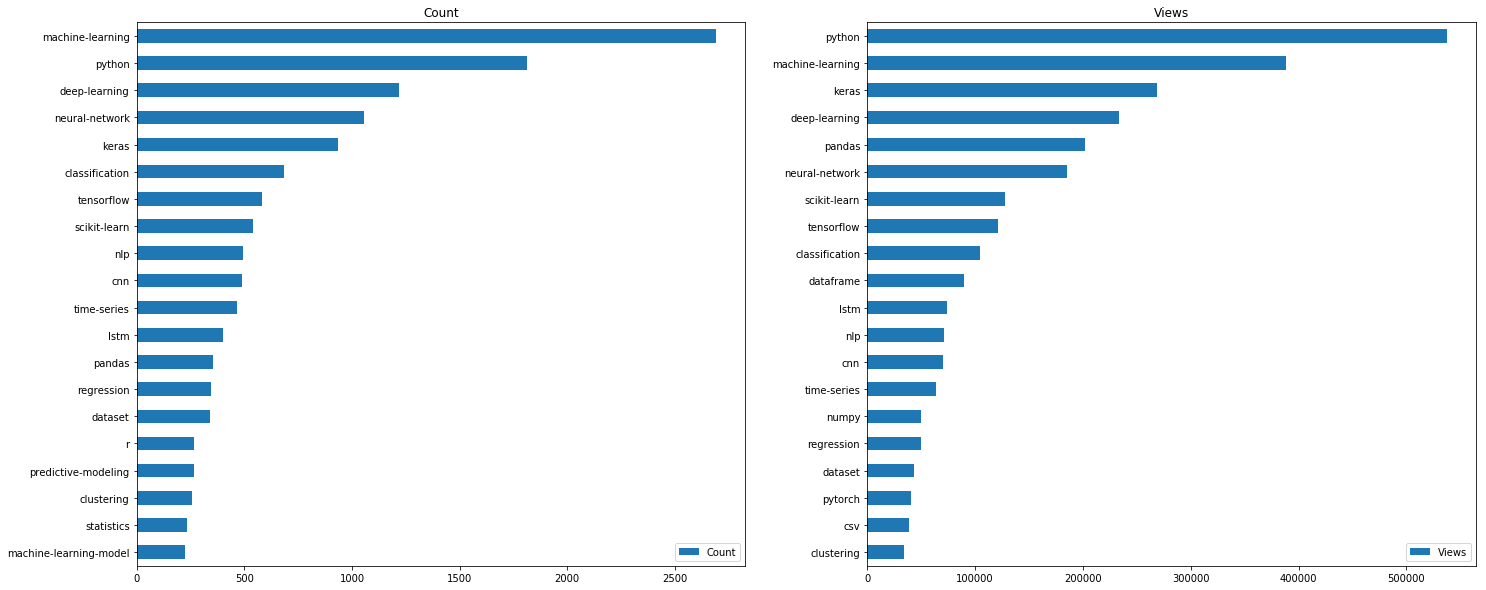

In [17]:
# View Tags and Views plots adjacently
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)
plt.show()

Viewing the plots side-by-side gives us a visual sense of the tags most shared by both dataframes. Merging these dataframes together yields a clearer numerical picture of common tags' occurrences.

In [18]:
in_used = pd.merge(most_used, most_viewed, how = "left", left_index = True, right_index = True)
in_used

,Count,Views
machine-learning-model,224,NaN
statistics,234,NaN
clustering,257,33928.0
predictive-modeling,265,NaN
r,268,NaN
dataset,340,43151.0
regression,347,49451.0
pandas,354,201787.0
lstm,402,74458.0
time-series,466,64134.0


In [19]:
in_viewed = pd.merge(most_viewed, most_used, how = "left", left_index = True, right_index = True)
in_viewed

,Views,Count
clustering,33928,257.0
csv,38654,NaN
pytorch,40240,NaN
dataset,43151,340.0
regression,49451,347.0
numpy,49767,NaN
time-series,64134,466.0
cnn,70349,489.0
nlp,71382,493.0
lstm,74458,402.0


## Relations Between Tags

One way of gauging the relationship between pairs of tags is to track how often they appear together. We can accomplish this by creating a dataframe where each row and column is a specific tag and all cells are zeros. Each index location will be incremented when the given tag pair to which it corresponds is found in the original `data` object consisting of all posted questions from 2019.

In [20]:
all_tags = list(tag_count.index)

In [21]:
# Create new associations dataframe filled with zeros
associations = pd.DataFrame(index = all_tags, columns = all_tags)
associations.fillna(0, inplace = True)

In [22]:
# Increment for each occurrence of association within the same post between two tags
for tags in data["Tags"]:
    associations.loc[tags, tags] += 1

To help understand what's going on in the dataframe, we can add color.

In [23]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


The cells highlighted in yellow tell us that 'time-series' was used together with 'r' 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that 'machine-learning' was used 2693 times and we confirm it in this dataframe.

To make the tag-tag associations even clearer, we can utilize Seaborn to create a heatmap. Darker colors correspond to higher values and a stronger association between the usage of two particular tags.

In [24]:
# Insert diagonal line of null associations between a tag and itself
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

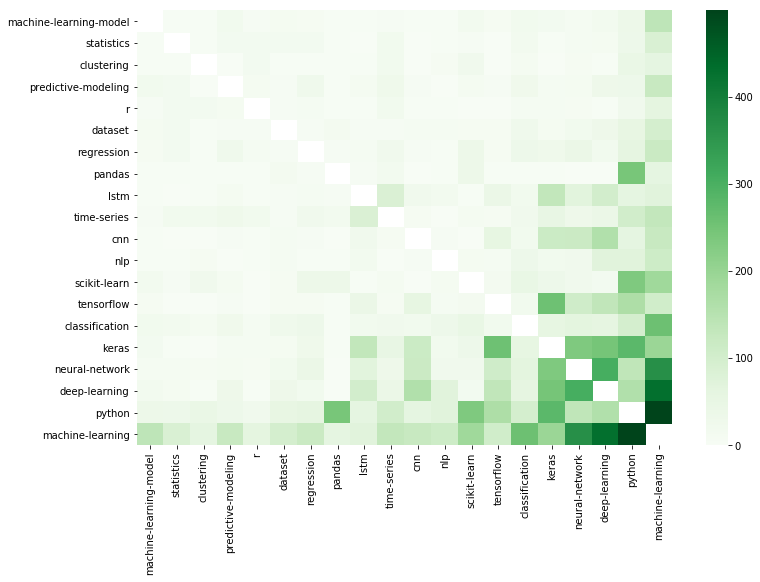

In [25]:
# Create heatmap
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used often, and so end up being used together without any truly strong relation between them.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, 'dataset' and 'scikit-learn' have a "strong" relation to 'pandas', but each by itself doesn't.

Keras, scikit-learn, and TensorFlow are all Python libraries that allow their users to employ deep learning. Most of the top tags, including these three, are all intimately related with the theme of deep learning. If we want to be very specific, we can suggest that the most popular newly created content would be Python content that uses deep learning for classification problems.

## Tracking Deep Learning Questions

In this final section, we'll build on the conclusion that most top tags are related to deep learning by charting the popularity of deep learning across multiple years. The results of this analysis will provide concrete insight about whether or not to recommend that deep learning and related themes be the focus of new content created and promoted on Data Science Stack Exchange.

We'll start by reading in and cleaning the tags of a dataset containing all questions, not just those posted in 2019.

In [26]:
# Read data and parse dates
all_q = pd.read_csv("all_questions.csv", parse_dates = ["CreationDate"])

In [27]:
# Clean Tags column
all_q["Tags"] = all_q["Tags"].str.replace("><", ",").str.replace("<|>", "").str.split(",")

To visualize the popularity of deep learning-related tags over time, we'll chart the number of posts containing these themes quarterly from Q2 of 2014 to Q4 of 2019.

The following steps will increment a new binary 'DeepLearning' column in the dataframe `all_q` for all posts containing at least one deep learning-related tag, shown in the list below.

In [28]:
dl_list = ["cnn", "lstm", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

In [29]:
# Function that increments a binary variable for each post containing a deep learning tag
def dl_classification(tags):
    for i in tags:
        if i in dl_list:
            return 1
    return 0

In [30]:
all_q["DeepLearning"] = all_q["Tags"].apply(dl_classification)

In [31]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
1633,711,2014-07-09 12:22:22,"[data-mining, svm, state-of-the-art]",0
2831,15922,2016-12-25 19:11:40,[text-mining],0
17207,32264,2018-05-28 13:16:29,"[cross-validation, evaluation]",0
5089,17060,2017-02-19 18:25:26,"[python, tensorflow, keras]",1
20919,66225,2020-01-09 22:24:00,"[python, keras, rnn]",1


We find that the process has worked as expected; posts containing one of the specified deep learning tags are now marked as such.

Since we don't have complete data for 2020, we'll filter out all posts from that year before writing a function that creates an `all_q` column denoting the quarter in which a post was composed. This column, along with the year of the post, will segment the data and prepare it for quarterly tracking.

In [32]:
# Remove 2020 data
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

In [33]:
# Define quarter-assigning function
def quarter(datetime):
    year = str(datetime.year)[-2:]    # Strip year from date
    month = int(datetime.month)       # Strip month
    
    # Assign post to particular quarter based on month
    if month < 4:
        quarter = 1
    elif 4 <= month < 7:
        quarter = 2
    elif 7<= month < 10:
        quarter = 3
    else:
        quarter = 4
        
    # Return newly formatted year and quarter
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(quarter)

Armed with all the tools necessary to formulate our final analysis, we can group the `quarterly` data by quarter, chart the number of deep learning posts versus total posts, and calculate the ratio of these values.

In [34]:
# Group data by quarter
quarterly = all_q.groupby("Quarter").agg({"DeepLearning":["sum", "size"]})

# Create new columns
quarterly.columns = ["DeepLearningQuestions", "TotalQuestions"]

# Find ratio of deep learning posts to total posts
quarterly["Ratio"] = quarterly["DeepLearningQuestions"] / quarterly["TotalQuestions"]

quarterly.reset_index(inplace = True)

In [35]:
quarterly

,Quarter,DeepLearningQuestions,TotalQuestions,Ratio
0,14Q2,9,157,0.057325
1,14Q3,13,189,0.068783
2,14Q4,21,216,0.097222
3,15Q1,18,190,0.094737
4,15Q2,28,284,0.098592
5,15Q3,45,311,0.144695
6,15Q4,66,382,0.172775
7,16Q1,110,516,0.213178
8,16Q2,109,518,0.210425
9,16Q3,161,585,0.275214


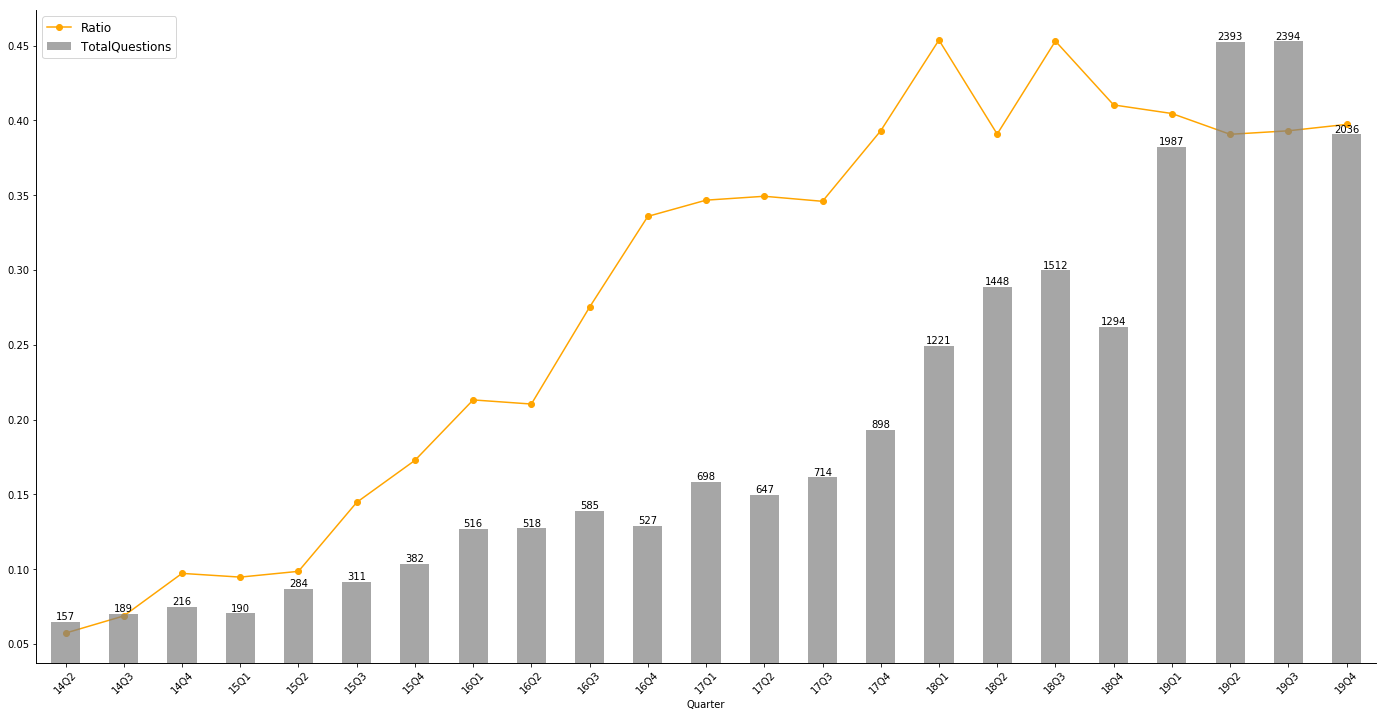

In [36]:
# Plot data
ax1 = quarterly.plot(x="Quarter", y="Ratio",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45, color = "gray")

for idx, t in quarterly["TotalQuestions"].iteritems():
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)
plt.show()

Plotting the per-quarter post totals and ratios of deep learning posts to total posts, we see that since 2014 deep learning has been a high-growth trend on Data Science Stack Exchange that is now starting to plateau. There's no evidence to suggest that on-site interest in it is waning, so we should proceed with our recommendation that newly created content for Data Science Stack Exchange focus on topics in deep learning.

## Conclusion

The goal of this project was to explore the question and answer format of Data Science Stack Exchange and make a recommendation for the focus of new content based on the most popular trends and topics on the site. By exploring the tags under which posts are classified, we determined that the site features substantial collective interest in topics related to deep learning, a trend that has grown and stabilized over the course of the past 5+ years.